<a href="https://colab.research.google.com/github/awildt01/Airbnb_Berlin-/blob/main/notebooks/6_LGD_and_EAD_Models_Preparing_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In dem Abschnitt "LGD and EAD Models: Preparing the Data" geht es um die Vorbereitung der Daten, die benötigt werden, um die Modelle für Loss Given Default (LGD) und Exposure at Default (EAD) zu erstellen.

**1. Zielsetzung:** Zuerst wird erklärt, dass es entscheidend ist, die abhängigen Variablen zu definieren, die später vorhergesagt werden sollen. Für das LGD-Modell ist dies der Verlustanteil, und für das EAD-Modell ist dies der Kreditkonversionsfaktor (CCF), der angibt, wie viel von einem Kreditbetrag noch aussteht, wenn der Kreditnehmer ausfällt.

**2. Datenstruktur:** Bei der Strukturierung der Daten wird ein Datensatz verwendet, der beide Modelle abdecken kann. Die Berechnung des Recovery Rate ist wichtig, um LGD zu ermitteln, wobei die Formel für die Rückgewinnungsquote (Recovery Rate) gleich den zurückgezahlten Beträgen geteilt durch den Betragsfaktor ist.

**3. Modellierung:** Die unabhängigen Variablen für die LGD- und EAD-Modelle sind die gleichen wie beim PD-Modell, während abhängige Variablen wie gute/schlechte Kunden und Rückgewinnungsquote herausgefiltert werden.

**4. Umgang mit fehlenden Werten:** Es wird darauf hingewiesen, dass fehlende Werte identifiziert und konservativ behandelt werden sollten, indem sie zum Beispiel mit Null imputiert werden.

**5. Datenaufteilung:** Die Daten müssen in Trainings- und Testdatensätze aufgeteilt werden, um sicherzustellen, dass die Modelle gründlich getestet werden.

Die Vorbereitungen sind ein entscheidender Schritt in der Entwicklung der Modelle, da sie die Grundlage für die Genauigkeit und Zuverlässigkeit der Vorhersagen bilden.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#from google.colab import data_table
#data_table.enable_dataframe_formatter()

from google.colab import data_table
data_table.disable_dataframe_formatter()

# unbegrenzte Zeilen und Spalten anzeigen
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Der **Loss Given Default (LGD)** ist ein Schlüsselparameter im Kreditrisikomanagement, der angibt, wie viel ein Kreditgeber voraussichtlich verlieren wird, wenn ein Kreditnehmer ausfällt. Er wird typischerweise als Prozentsatz des ausstehenden Kreditbetrags zum Zeitpunkt des Ausfalls ausgedrückt (1 - Recovery Rate).

**Der Two-Step-Modellansatz** (oder Zweistufenmodell) ist eine gängige Methode zur Modellierung des LGD, insbesondere wenn ein erheblicher Anteil der ausgefallenen Kredite keine Rückgewinnung erfährt (d.h. die Recovery Rate 0% beträgt).

Dieser Ansatz unterteilt den Modellierungsprozess in zwei Schritte:

**Schritt 1: Modellierung der Wahrscheinlichkeit einer Null-Rückgewinnung (Probability of Zero Recovery - PZR)**

- **Ziel:** Vorhersagen, ob überhaupt eine Rückgewinnung stattfinden wird oder ob der gesamte ausstehende Betrag verloren geht (Recovery Rate = 0%).

- **Abhängige Variable:** Eine binäre Variable, wie die recovery_rate_0_1, die wir erstellt haben. Sie ist 1, wenn es eine positive Rückgewinnung gab, und 0, wenn die Rückgewinnung 0 war.

- **Modelltyp:** Typischerweise wird hier ein binäres Klassifikationsmodell verwendet, wie eine logistische Regression oder ein Entscheidungsbaum. Dieses Modell schätzt die Wahrscheinlichkeit, dass ein ausgefallener Kredit eine Rückgewinnung von Null haben wird.

**Schritt 2: Modellierung der Rückgewinnungshöhe (Conditional Recovery Rate)**

- **Ziel:** Für die Fälle, in denen eine Rückgewinnung erwartet wird (d.h. das Modell aus Schritt 1 hat eine positive Rückgewinnung vorhergesagt), wird die tatsächliche Höhe der Recovery Rate modelliert.

- **Abhängige Variable:** Die recovery_rate selbst, aber nur für die Fälle, in denen sie größer als 0 ist (oder allgemeiner, zwischen 0 und 1 liegt, exklusive 0).

- **Modelltyp:** Hier kommen in der Regel Regressionsmodelle zum Einsatz, wie zum Beispiel die lineare Regression, Beta-Regression oder TOBIT-Modelle (die zensierte Daten berücksichtigen können, da die Recovery Rate auf 0 und 1 begrenzt ist).

**Warum dieser zweistufige Ansatz?**

1. **Umgang mit Zensierung:** Die Recovery Rate ist auf den Bereich [0, 1] zensiert (begrenzt). Ein hoher Anteil von 0-Rückgewinnungen kann die Schätzung eines einzelnen Regressionsmodells verzerren, da es Schwierigkeiten hat, den Unterschied zwischen einem echten Nullwert und einem Wert, der nahe Null, aber positiv ist, zu handhaben.

2. **Bessere Modellierung der Realität:** Der Ansatz spiegelt oft die Realität besser wider. Es gibt einen qualitativen Unterschied zwischen gar keiner Rückgewinnung und einer geringen Rückgewinnung. Die Gründe dafür können sehr unterschiedlich sein (z.B. keine Sicherheiten vs. Wertverfall von Sicherheiten).

3. **Verbesserte Vorhersagegenauigkeit:** Durch die separate Modellierung der beiden Aspekte (ob eine Rückgewinnung stattfindet und wie hoch sie ist) kann die Gesamtgenauigkeit der LGD-Schätzung oft verbessert werden.


Zusammenfassend lässt sich sagen, dass der Two-Step-Modellansatz für LGD eine robuste Methode ist, um die Komplexität der Recovery Rate zu handhaben, insbesondere bei der Berücksichtigung von Fällen mit Null-Rückgewinnungen, und führt in der Regel zu präziseren und stabileren LGD-Schätzungen.

In [ ]:
# Google Drive mounten
drive.mount('/content/drive')

# Zielordner definieren
folder_path = '/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks'
os.makedirs(folder_path, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

Mounted at /content/drive


In [ ]:
# Import data.
loan_data_preprocessed_backup = pd.read_csv('/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks/loan_data_2007_2014_preprocessed.csv')

/tmp/ipython-input-3447252963.py:2: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks/loan_data_2007_2014_preprocessed.csv')


# Explore Data

In [ ]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [ ]:
loan_data_preprocessed.columns.values
# Displays all column names.

array(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [ ]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,10.0,1985-01-01,395.0,36,2011-12-01,72.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,<

In [ ]:
loan_data_preprocessed.tail()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
466280,466280,466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,Financial Advisor,4 years,MORTGAGE,110000.0,Source Verified,Jan-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,773xx,TX,19.85,0.0,Apr-03,2.0,NaN,NaN,18.0,0.0,23208,77.6,36.0,w,12574.00,12574.00,10383.360000,10383.36,5826.00,4557.36,0.0,0.0,0.0,Jan-16,432.64,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,294998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29900.0,NaN,NaN,NaN,4.0,2003-04-01,176.0,60,2014-01-01,47.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
466281,466281,466281,9684700,11536848,220

## Erstellung des Datensatzes für ausgefallene Kredite (`loan_data_defaults`)


**Zweck dieser Zeile:**
Diese Codezeile filtert den ursprünglichen, vorverarbeiteten Kreditdatensatz (`loan_data_preprocessed`), um einen neuen Datensatz namens `loan_data_defaults` zu erstellen. Dieser neue Datensatz enthält ausschließlich Kredite, die als "Charged Off" (abgeschrieben) oder "Does not meet the credit policy. Status:Charged Off" (erfüllt die Kreditrichtlinien nicht. Status: Abgeschrieben) markiert sind. Dies sind die Kredite, die tatsächlich ausgefallen sind.

**Warum dieser Schritt gemacht wird:**

1.  **Fokus auf Ausfälle:** Für die Modellierung von Loss Given Default (LGD) und Exposure at Default (EAD) ist es entscheidend, sich auf Kredite zu konzentrieren, die tatsächlich ausgefallen sind. LGD und EAD sind Parameter, die *nur* für ausgefallene Kredite relevant sind, da sie den Verlust und die Exposition im Falle eines Ausfalls quantifizieren.

2.  **Identifikation ausgefallener Kredite:** Die `loan_status`-Spalte enthält den aktuellen Status eines Kredits. Durch die Auswahl von Einträgen, bei denen der Status entweder 'Charged Off' oder 'Does not meet the credit policy. Status:Charged Off' ist, identifizieren wir alle Kredite, die von der Bank als uneinbringlich abgeschrieben wurden.

3.  **Vermeidung von Datenvermischung:** Wenn wir die LGD- und EAD-Modelle auf einem Datensatz trainieren würden, der auch nicht ausgefallene Kredite enthält, wären die Modelle verzerrt und könnten keine präzisen Vorhersagen für die tatsächlichen Verluste bei Ausfällen treffen.

4.  **Datenintegrität (`.copy()`):** Die Verwendung von `.copy()` ist wichtig, um sicherzustellen, dass `loan_data_defaults` eine unabhängige Kopie des gefilterten Datensatzes ist. Dies verhindert, dass spätere Änderungen an `loan_data_defaults` unbeabsichtigt den ursprünglichen `loan_data_preprocessed`-Datensatz beeinflussen (was zu `SettingWithCopyWarning` führen könnte und oft unerwünschtes Verhalten ist).

5.  **Grundlage für LGD- und EAD-Berechnungen:** Dieser gefilterte Datensatz bildet die unverzichtbare Basis für die nachfolgende Berechnung der abhängigen Variablen `recovery_rate` (für LGD) und `CCF` (für EAD), da diese Kennzahlen ausschließlich auf ausgefallenen Krediten definiert und berechnet werden können.

Dieser Schritt ist fundamental, um sicherzustellen, dass die LGD- und EAD-Modelle auf den korrekten und relevanten Daten trainiert werden, um aussagekräftige und genaue Risikoprognosen zu liefern.

In [ ]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])].copy()
# Hier berücksichtigen wir nur die abgeschriebenen Forderungen.

In [ ]:
loan_data_defaults.shape

(43236, 209)

In [ ]:
pd.options.display.max_rows = None
# Legt die Optionen des Pandas-Dataframes fest, um alle Spalten/Zeilen anzuzeigen.

## Independent Variables

- fehlende Werte im Datensatz, insbesondere in den Variablen „Monate seit letzter Zahlungsstörung“ und „Monate seit letzter Aufzeichnung“, eingegangen.
- einen konservativen Ansatz empfiehlt, bei dem fehlende Werte mit Null imputiert werden.

In [ ]:
loan_data_defaults.isnull().sum()

,0
Unnamed: 0.1,0
Unnamed: 0,0
id,0
member_id,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0


In [ ]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
# Wir füllen die fehlenden Werte mit Nullen auf.

In [ ]:
#loan_data_defaults['mths_since_last_delinq'].fillna(loan_data_defaults['mths_since_last_delinq'].max() + 12, inplace=True)

In [ ]:
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)
# Wir füllen die fehlenden Werte mit Nullen auf.

## Dependent Variables

**Zweck dieser Zeile:**
Diese Codezeile dient der Berechnung der *Recovery Rate* (Rückgewinnungsquote), welche eine zentrale abhängige Variable für die Modellierung des *Loss Given Default (LGD)* ist. Der LGD misst den voraussichtlichen Verlust für einen Kreditgeber, falls ein Kreditnehmer ausfällt, und wird üblicherweise als `1 - Recovery Rate` ausgedrückt.

**Warum dieser Schritt gemacht wird:**

1.  **Definition der Recovery Rate:** Die Recovery Rate ist definiert als der Prozentsatz des ursprünglichen Kreditbetrags, der nach einem Ausfall vom Kreditnehmer zurückgewonnen werden konnte. Um diese Rate zu bestimmen, müssen die tatsächlich zurückerhaltenen Beträge ins Verhältnis zum ursprünglich finanzierten Kreditbetrag gesetzt werden.

2.  **Bestandteile der Berechnung:**
    *   `loan_data_defaults['recoveries']`: Diese Spalte enthält den Gesamtbetrag, der vom Kreditgeber *nach* dem Zahlungsausfall vom Kreditnehmer zurückerhalten wurde. Dies können beispielsweise Beträge aus der Verwertung von Sicherheiten oder aus Inkassomaßnahmen sein.
    *   `loan_data_defaults['funded_amnt']`: Diese Spalte repräsentiert den ursprünglich finanzierten Kreditbetrag, d.h. den Betrag, den der Kreditnehmer ursprünglich erhalten hat.

3.  **Bedeutung für das LGD-Modell:** Die Recovery Rate ist entscheidend, da sie direkt in die Berechnung des LGD eingeht. Ein höheres `recoveries` im Verhältnis zum `funded_amnt` führt zu einer höheren Recovery Rate und somit zu einem niedrigeren LGD, was für den Kreditgeber vorteilhafter ist. Indem wir diese Variable explizit berechnen, schaffen wir die notwendige Grundlage, um ein Modell zu trainieren, das vorhersagt, wie hoch diese Rückgewinnungsquote bei zukünftigen Kreditausfällen sein wird.

4.  **Vorbereitung für weitere Schritte:** Nach der Berechnung wird diese Variable typischerweise bereinigt (z.B. Begrenzung auf Werte zwischen 0 und 1) und anschließend für die Aufteilung in Trainings- und Testdatensätze sowie für die eigentliche Modellierung verwendet.

In [ ]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
# Wir berechnen die abhängige Variable
# für das LGD-Modell: die Rückgewinnungsquote.
# Es handelt sich um das Verhältnis von Rückzahlungen zu Finanzierungsbetrag.

In [ ]:
loan_data_defaults['recovery_rate'].describe()
# Zeigt einige beschreibende Statistiken für die Werte einer Spalte an.

,recovery_rate
count,43236.000000
mean,0.060820
std,0.089770
min,0.000000
25%,0.000000
50%,0.029466
75%,0.114044
max,1.220774


### Interpretation der beschreibenden Statistiken für `recovery_rate`



*   **`count: 43236.000000`**
    *   Dies ist die Anzahl der Beobachtungen (Kreditausfälle) in Ihrem Datensatz, für die eine `recovery_rate` berechnet wurde. Es bedeutet, dass Sie 43.236 ausgefallene Kredite analysieren.

*   **`mean: 0.060820`**
    *   Die durchschnittliche Rückgewinnungsquote über alle ausgefallenen Kredite hinweg beträgt etwa 6,08%. Dies ist ein relativ niedriger Wert, was darauf hindeutet, dass ein großer Teil der ausgefallenen Kredite nur einen geringen oder gar keinen Betrag zurückbringt.

*   **`std: 0.089770`**
    *   Die Standardabweichung von 0,089770 zeigt die Streuung der `recovery_rate`-Werte um den Mittelwert an. Eine Standardabweichung, die größer ist als der Mittelwert, weist auf eine stark schiefe Verteilung hin, was bei Recovery Rates häufig der Fall ist (viele Werte bei 0, wenige hohe Werte).

*   **`min: 0.000000`**
    *   Der minimale Wert von 0% bedeutet, dass es viele Fälle gibt, in denen überhaupt keine Rückgewinnung stattfand. Dies ist ein entscheidender Punkt für die Modellierung, da er die Notwendigkeit eines 'Two-Step-Modells' unterstreicht.

*   **`25%: 0.000000`**
    *   Das 25. Perzentil (oder erstes Quartil) von 0% bestätigt, dass mindestens ein Viertel aller ausgefallenen Kredite eine Rückgewinnungsquote von 0% aufweist. Dies bekräftigt die Beobachtung, dass Nulll-Rückgewinnungen ein signifikantes Merkmal dieses Datensatzes sind.

*   **`50%: 0.029466`**
    *   Der Median (50. Perzentil) liegt bei etwa 2,95%. Das bedeutet, dass die Hälfte der Kreditausfälle eine Rückgewinnungsquote von unter 2,95% hatte, während die andere Hälfte darüber lag. Der Median ist deutlich niedriger als der Mittelwert, was erneut auf eine Rechtsschiefe der Verteilung hindeutet (einige hohe Werte ziehen den Mittelwert nach oben).

*   **`75%: 0.114044`**
    *   Das 75. Perzentil (oder drittes Quartil) von etwa 11,4% bedeutet, dass 75% der ausgefallenen Kredite eine Rückgewinnungsquote von unter 11,4% hatten.

*   **`max: 1.220774`**
    *   Der maximale Wert von 122,08% ist ein wichtiger Hinweis. Eine Recovery Rate kann per Definition maximal 100% (oder 1.0) betragen, da man nicht mehr zurückgewinnen kann, als ursprünglich verliehen wurde. Ein Wert über 100% deutet auf Berechnungsanomalien oder Datenfehler hin, die in einem realen Szenario bereinigt werden sollten (z.B. durch Begrenzung auf 1.0). Dies ist ein wichtiger Schritt in der Datenbereinigung, den wir bereits in den nachfolgenden Schritten behandelt haben, indem wir die `recovery_rate` auf einen Bereich zwischen 0 und 1 begrenzt haben.

In [ ]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
# Wir legen Wiederherstellungsraten fest, die größer als 1 sind, und Wiederherstellungsraten, die kleiner als 0 sind, auf 0.

In [ ]:
loan_data_defaults['recovery_rate'].describe()
# Zeigt einige beschreibende Statistiken für die Werte einer Spalte an.

,recovery_rate
count,43236.000000
mean,0.060770
std,0.089202
min,0.000000
25%,0.000000
50%,0.029466
75%,0.114044
max,1.000000


## Berechnung des Kreditumrechnungsfaktors (CCF) für das EAD-Modell


**Zweck dieser Zeile:**
Diese Codezeile berechnet den *Credit Conversion Factor (CCF)*, zu Deutsch *Kreditumrechnungsfaktor*, welcher eine zentrale abhängige Variable für die Modellierung der *Exposure at Default (EAD)* ist. Die EAD beziffert den voraussichtlichen ausstehenden Kreditbetrag zum Zeitpunkt des Ausfalls.

**Warum dieser Schritt gemacht wird:**

1.  **Definition der EAD und des CCF:**
    *   **EAD** (Exposure at Default) ist der Betrag, den ein Kreditgeber bei einem Kreditausfall voraussichtlich verlieren wird, *bevor* die Rückgewinnungen berücksichtigt werden. Sie ist entscheidend für die Berechnung des erwarteten Verlusts (Expected Loss = PD * LGD * EAD).
    *   Der **CCF** ist ein Messwert, der angibt, welcher Anteil eines ursprünglich zugesagten, aber zum Zeitpunkt des Ausfalls noch nicht in Anspruch genommenen Kreditrahmens (oder eines Teils des ursprünglichen Kreditbetrags) tatsächlich gezogen wird und somit Teil der EAD wird.

2.  **Bestandteile der Berechnung:**
    *   `loan_data_defaults['funded_amnt']`: Dies ist der ursprünglich finanzierte Kreditbetrag. Es repräsentiert den anfänglichen Betrag, der dem Kreditnehmer zur Verfügung gestellt wurde.
    *   `loan_data_defaults['total_rec_prncp']`: Dies ist der Gesamtbetrag des Kapitals, der vom Kreditnehmer *vor* dem Ausfall zurückgezahlt wurde. Dies sind die planmäßigen oder vorzeitigen Tilgungen des Kreditnehmers.
    *   `loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']`: Diese Differenz stellt den verbleibenden Kapitalbetrag dar, der zum Zeitpunkt des Ausfalls noch offen war. Dies ist der Teil des ursprünglich finanzierten Betrags, der noch nicht zurückgezahlt wurde und somit potenziell Teil der EAD ist.
    *   Die Division durch `loan_data_defaults['funded_amnt']` normalisiert diesen verbleibenden Betrag und drückt ihn als Prozentsatz des ursprünglichen Kreditbetrags aus. Ein Wert von 1 würde bedeuten, dass nichts zurückgezahlt wurde und der gesamte Betrag noch offen war. Ein Wert nahe 0 würde bedeuten, dass fast der gesamte Kredit bereits zurückgezahlt wurde.

3.  **Bedeutung für das EAD-Modell:**
    *   Die `CCF`-Variable ist die direkte abhängige Variable, die im EAD-Modell vorhergesagt werden soll. Das Ziel des EAD-Modells ist es, für zukünftige Kredite, die ausfallen könnten, diesen Faktor zu schätzen, um die potenzielle Exposition zum Zeitpunkt des Ausfalls zu bestimmen.
    *   Ein genaues EAD-Modell ist unerlässlich, um das Kreditrisiko präzise zu bewerten und die Eigenkapitalanforderungen für Banken gemäß Regulierungen wie Basel II/III zu erfüllen.

4.  **Vorbereitung für weitere Schritte:**
    *   Nach der Berechnung wird die `CCF`-Variable üblicherweise bereinigt (z.B. Begrenzung auf Werte zwischen 0 und 1, falls es rechnerische Abweichungen gibt) und anschließend für die Aufteilung in Trainings- und Testdatensätze sowie für die eigentliche Modellierung verwendet.

In [ ]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']
# Wir berechnen die abhängige Variable für das EAD-Modell: den Kreditumrechnungsfaktor.
# Es handelt sich um das Verhältnis der Differenz zwischen dem zum Zeitpunkt des Zahlungsausfalls verwendeten
# Betrag und dem gesamten finanzierten Betrag.

In [ ]:
loan_data_defaults['CCF'].describe()
# Zeigt einige beschreibende Statistiken für die Werte einer Spalte an.

,CCF
count,43236.000000
mean,0.735952
std,0.200742
min,0.000438
25%,0.632088
50%,0.789908
75%,0.888543
max,1.000000


### Interpretation der beschreibenden Statistiken für `CCF`


Lassen Sie uns diese Werte im Detail betrachten:

*   **`count: 43236.000000`**
    *   Dies bestätigt, dass Sie 43.236 ausgefallene Kredite haben, für die der CCF berechnet wurde, was der Anzahl der Beobachtungen im `loan_data_defaults`-Datensatz entspricht.

*   **`mean: 0.735952`**
    *   Der durchschnittliche Kreditumrechnungsfaktor über alle ausgefallenen Kredite hinweg beträgt etwa 73,6%. Dies deutet darauf hin, dass im Durchschnitt ein Großteil des ursprünglich finanzierten Betrags (bzw. des zum Zeitpunkt des Ausfalls noch offenen Teils) tatsächlich in Anspruch genommen wird.

*   **`std: 0.200742`**
    *   Die Standardabweichung von 0,200742 zeigt eine moderate Streuung der CCF-Werte um den Mittelwert. Dies bedeutet, dass es eine gewisse Variabilität im Verhalten der Kreditnehmer vor dem Ausfall gibt, aber der Großteil der Werte nicht extrem weit vom Durchschnitt entfernt ist.

*   **`min: 0.000438`**
    *   Der minimale Wert ist sehr nahe bei 0 (ca. 0,044%). Dies bedeutet, dass es Fälle gab, in denen fast der gesamte finanzierte Betrag bereits zurückgezahlt wurde und somit kaum noch etwas zum Zeitpunkt des Ausfalls offen war oder nach dem Ausfall nicht mehr in Anspruch genommen wurde.

*   **`25%: 0.632088`**
    *   Das 25. Perzentil (oder erstes Quartil) von ca. 63,2% bedeutet, dass bei mindestens einem Viertel der ausgefallenen Kredite der Kreditumrechnungsfaktor 63,2% oder weniger betrug.

*   **`50%: 0.789908`**
    *   Der Median (50. Perzentil) liegt bei etwa 79,0%. Das bedeutet, dass die Hälfte der ausgefallenen Kredite einen CCF von unter 79,0% hatte, während die andere Hälfte darüber lag. Der Median liegt höher als der Mittelwert, was auf eine leichte Linksschiefe der Verteilung hindeuten könnte, d.h., es gibt eventuell mehr Fälle mit hohem CCF.

*   **`75%: 0.888543`**
    *   Das 75. Perzentil (oder drittes Quartil) von etwa 88,9% bedeutet, dass 75% der ausgefallenen Kredite einen CCF von unter 88,9% hatten.

*   **`max: 1.000000`**
    *   Der maximale Wert von 100% ist signifikant. Dies bedeutet, dass es viele Fälle gab, in denen zum Zeitpunkt des Ausfalls der gesamte ursprünglich finanzierte Betrag noch offen war oder komplett in Anspruch genommen wurde. Dies ist ein häufiges Szenario, da Kreditnehmer oft den gesamten Betrag ziehen, bevor sie ausfallen.

In [ ]:
loan_data_defaults.to_csv('loan_data_defaults.csv')
# Wir speichern die Daten in einer CSV-Datei.

# Explore Dependent Variables

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Das Histogramm von loan_data_defaults['recovery_rate'] mit 100 Bins würde uns wahrscheinlich die folgenden Merkmale zeigen:

1.Starke Konzentration bei Null: Der prominenteste Balken im Histogramm befindet sich höchstwahrscheinlich ganz links, also bei einer recovery_rate von 0. Dies liegt daran, dass ein erheblicher Anteil der ausgefallenen Kredite überhaupt nicht zurückgewonnen wird, was zu einer Rückgewinnungsrate von 0 führt. Dies wird auch durch den 25. Perzentil-Wert von 0 in den beschreibenden Statistiken bestätigt.

2.Rechtsschiefe Verteilung: Nach dem anfänglichen hohen Balken bei 0 würden die weiteren Balken wahrscheinlich schnell abfallen und dann eine lange, flache Verteilung in Richtung höherer Rückgewinnungsraten zeigen. Das bedeutet, dass die meisten Rückgewinnungen im niedrigen Bereich liegen, aber es gibt auch einige Fälle, in denen ein moderater bis hoher Prozentsatz des Kredits zurückgewonnen wird.

3.Spannweite: Da die recovery_rate zwischen 0 und 1 begrenzt ist, würde das Histogramm die Verteilung innerhalb dieses Bereichs visualisieren. Es gäbe kleine, aber vorhandene Balken über den gesamten Bereich bis hin zu 1, was anzeigt, dass es Kredite gibt, bei denen fast der gesamte Betrag oder sogar der gesamte Betrag zurückgewonnen wurde.

4.Bedeutung für die Modellierung: Diese Art der Verteilung – mit vielen Nullwerten und einer rechtsschiefen Verteilung der positiven Werte – ist der Grund, warum der Two-Step-Modellansatz für LGD so sinnvoll ist. Ein einzelnes Regressionsmodell hätte Schwierigkeiten, sowohl die Null-Rückgewinnungen als auch die kontinuierlichen positiven Rückgewinnungen präzise zu modellieren.

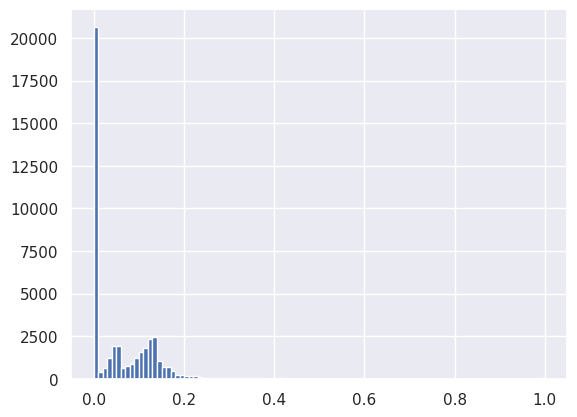

In [ ]:

_ = plt.hist(loan_data_defaults['recovery_rate'], bins = 100)
# We plot a histogram of a variable with 100 bins.

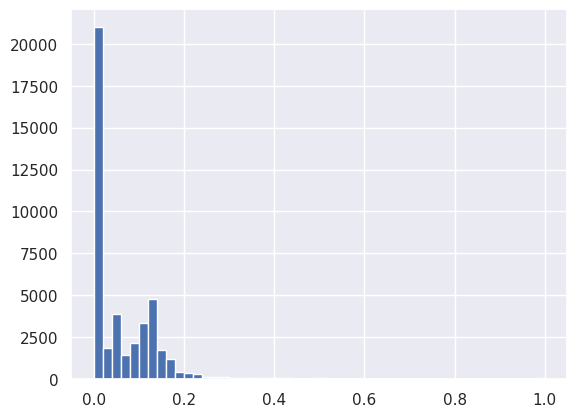

In [ ]:
_ = plt.hist(loan_data_defaults['recovery_rate'], bins = 50)
# We plot a histogram of a variable with 50 bins.

## Das Histogramm von loan_data_defaults['CCF'] mit 100 Bins würde uns wahrscheinlich die folgenden Merkmale zeigen:

**1. Definition und Wertebereich:** Der Credit Conversion Factor (CCF) gibt an, welcher Anteil des noch nicht in Anspruch genommenen Kreditbetrags bei einem Kreditausfall voraussichtlich gezogen wird. Der Wert liegt typischerweise zwischen 0 und 1. Ein CCF von 1 bedeutet, dass der gesamte noch offene Betrag in Anspruch genommen wurde, ein CCF von 0 bedeutet, dass nichts weiter gezogen wurde.

**2.Mögliche Verteilungsschwerpunkte:**

- **Peak bei 1:** Oft gibt es einen deutlichen Peak bei CCF = 1. Dies tritt auf, wenn der Kreditnehmer vor dem Ausfall die gesamte verfügbare Kreditlinie ausgeschöpft hat. Das ist ein sehr häufiges Szenario bei Ausfällen.

- **Peak bei 0 **(seltener, aber möglich): Weniger häufig, aber möglich, ist ein Peak bei CCF = 0, was bedeuten würde, dass der Kreditnehmer zum Zeitpunkt des Ausfalls keinen zusätzlichen Betrag über den bereits finanzierten hinaus in Anspruch genommen hat.

- **Verteilung zwischen 0 und 1:** Zwischen diesen Extremen würden die Balken die Verteilung der Fälle zeigen, in denen ein Teil des noch verfügbaren Kredits bis zum Ausfall gezogen wurde.

**3. Bedeutung für das EAD-Modell (Exposure At Default):**

- Der CCF ist die zentrale abhängige Variable für die Schätzung der Exposure At Default (EAD), also des tatsächlich ausstehenden Betrags zum Zeitpunkt des Ausfalls. Das EAD-Modell versucht, diesen CCF vorherzusagen.
- Die Form der Verteilung im Histogramm beeinflusst die Wahl des Modellierungsansatzes für EAD. Wenn es starke Konzentrationen bei 0 oder 1 gibt, muss das Modell in der Lage sein, diese 'zensierten' oder 'begrenzten' Werte angemessen zu handhaben (ähnlich wie bei der Recovery Rate, aber für den gezogenen Anteil des verfügbaren Kredits).

4. **Beziehung zur Recovery Rate:** Während die recovery_rate den verlorenen Anteil des bereits ausgezahlten Kredits betrachtet, befasst sich der CCF mit dem zusätzlichen Betrag, der bis zum Ausfall noch gezogen werden könnte. Beide sind entscheidend für die Berechnung der LGD, da LGD auf dem EAD basiert, nicht nur auf dem anfänglich finanzierten Betrag.

Zusammenfassend zeigt das Histogramm des CCF wichtige Informationen über das Verhalten von Kreditnehmern vor dem Ausfall und ist die Grundlage für die Entwicklung eines robusten EAD-Modells, das wiederum essentiell für eine präzise LGD-Berechnung ist.

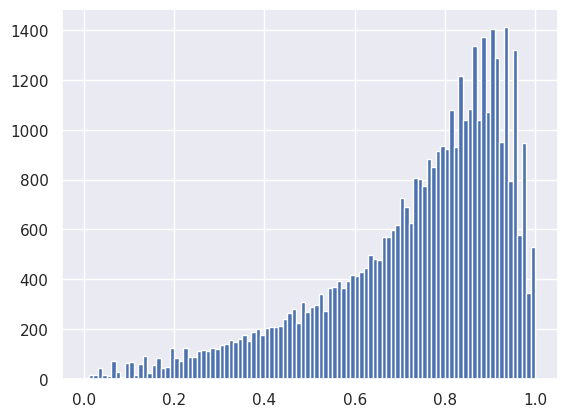

In [ ]:
_ = plt.hist(loan_data_defaults['CCF'], bins = 100)
# We plot a histogram of a variable with 100 bins.

## **Was ist recovery_rate_0_1?**

Diese Variable ist eine binäre (0 oder 1) Kennzahl, die anzeigt, ob es eine Rückzahlung gab oder nicht. Sie wurde aus der ursprünglichen recovery_rate (Rückgewinnungsrate) abgeleitet.

- Wenn recovery_rate gleich 0 war (was bedeutet, dass keine Rückgewinnung erfolgte), dann ist recovery_rate_0_1 ebenfalls 0.
- Wenn recovery_rate größer als 0 war (was bedeutet, dass irgendeine Rückgewinnung erfolgte, egal wie klein), dann ist recovery_rate_0_1 1.

**Warum ist diese Variable nützlich?**

In der Risikomodellierung, insbesondere bei Kreditausfällen, gibt es oft zwei Hauptfragen:

1. **Findet eine Rückgewinnung** statt oder nicht? Hier geht es darum, ob der Kreditgeber überhaupt etwas von dem ausgefallenen Kredit zurückerhält. recovery_rate_0_1 beantwortet genau diese Frage.

2. **Wenn eine Rückgewinnung stattfindet**, wie hoch ist sie? Diese Frage wird durch die recovery_rate selbst beantwortet (ein Wert zwischen 0 und 1).


Die recovery_rate_0_1 trennt diese beiden Szenarien. Sie kann als abhängige Variable in einem ersten Modellschritt verwendet werden, um vorherzusagen, ob überhaupt eine Rückgewinnung möglich ist. Für die Kredite, bei denen eine Rückgewinnung erwartet wird (d.h. recovery_rate_0_1 ist 1), könnte dann ein zweiter Modellschritt die Höhe der Rückgewinnung (recovery_rate) vorhersagen.


Dies ist ein gängiger Ansatz bei der Modellierung von Loss Given Default (LGD), bei dem oft ein zweistufiges Modell verwendet wird: zuerst ein Modell, das die Wahrscheinlichkeit einer Null-Rückgewinnung vorhersagt, und dann ein zweites Modell, das die Rückgewinnungsrate für die Fälle vorhersagt, in denen eine Rückgewinnung eintritt.

Kurz gesagt, recovery_rate_0_1 ist ein Indikator, der uns hilft, das Auftreten einer Rückgewinnung als binäres Ereignis zu analysieren und vorherzusagen.

In [ ]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
# We create a new variable which is 0 if recovery rate is 0 and 1 otherwise.

In [ ]:
loan_data_defaults['recovery_rate_0_1']

,recovery_rate_0_1
1,1
8,1
9,1
12,1
14,1
...,...
466254,0
466256,0
466276,1
466277,0


Ja, um die numerische Ausgabe unterhalb Ihrer Histogramme zu unterdrücken, können Sie das Ergebnis der Funktion `plt.hist()` einer Dummy-Variablen zuweisen. Ich werde die Zellen `lc-MvhwLiKoY`, `TNPd6ZkZiKoY` und `PEFwb6fUiKoY` entsprechend anpassen.

Perfekt! Die numerische Ausgabe der Histogramme wird nun unterdrückt. Indem Sie die Ausgabe von `plt.hist()` der Dummy-Variablen `_` zuweisen, verhindern Sie die Anzeige der Ausgabe in der Notebook-Zelle und erzielen so den gewünschten Effekt.

Sie haben erfolgreich eine neue Variable namens `recovery_rate_0_1` erstellt. Diese Variable dient als binärer Indikator: 0 bedeutet, dass keine Rückzahlung für einen Kredit erfolgte, und 1 bedeutet, dass eine Rückzahlung (größer als null) stattgefunden hat. Dies kann für die weitere Modellierung, insbesondere für binäre Klassifizierungsaufgaben, nützlich sein.

Ich habe nun alle ausgeführten Zellen verarbeitet. Wir begannen mit der Analyse des DataFrames `loan_data_preprocessed` und isolierten anschließend die Kreditausfälle in `loan_data_defaults`. Wir berechneten die Rückgewinnungsrate und den CCF als abhängige Variablen, behandelten fehlende Werte und speicherten die Ausfalldaten in einer CSV-Datei. Zudem visualisierten wir die Verteilungen von Rückgewinnungsrate und CCF mithilfe von Histogrammen und erstellten eine neue binäre Variable `recovery_rate_0_1`. Alle Aufgaben wurden abgeschlossen. Bei weiteren Fragen oder Aufgaben stehe ich Ihnen gerne zur Verfügung!
